Notebook objective: Train, tune & test LightGBM model, target encoding the country variable & using year as a numeric variable.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

from category_encoders.target_encoder import TargetEncoder
#from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, RepeatedKFold
from lightgbm import LGBMRegressor, early_stopping

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Set print options
np.set_printoptions(suppress=True, precision=6, edgeitems = 7)
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', None)

## Preprocessing

In [3]:
random_state = 1923

In [4]:
# Read data
df = pd.read_csv("./OutputData/training_data.csv")

In [5]:
# Split features and target
X = df.drop(["life_expectancy"], axis = 1)
y = df.life_expectancy

In [6]:
# Split train-test
X, X_test, y, y_test = train_test_split(X, y, test_size = 0.25, random_state = random_state) 
X = X.reset_index(drop = True)
y = y.reset_index(drop = True)

In [7]:
# Create CV splitter
#cv = StratifiedKFold(n_splits = 3)
cv = RepeatedKFold(n_splits = 3, n_repeats = 3, random_state = random_state)

In [9]:
# Create target encoder
encoder = TargetEncoder(cols = "country")

## Hyperparameter tuning

In [9]:
# Objective function
def objective_lgbm(trial):

    # Define hyperparameter space
    learning_rate = trial.suggest_float("learning_rate", 0.05, 0.5)
    num_leaves = trial.suggest_int("num_leaves", 2**2, 2**10)
    min_child_samples = trial.suggest_int("min_child_samples", 10, 1000, log = True)
    min_child_weight = trial.suggest_int("min_child_weight", 0.001, 20)
    reg_alpha = trial.suggest_float("l1_reg", 5e-5, 1, log = True)
    reg_lambda = trial.suggest_float("l2_reg", 0, 2)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.25, 1)

    # Store tuning scores & number of rounds
    scores = []
    rounds = []

    for i, (train_index, val_index) in enumerate(cv.split(X)):

        # Split train - val
        X_train, y_train = X.iloc[train_index, ], y[train_index]
        X_val, y_val = X.iloc[val_index, ], y[val_index]

        # Perform target encoding
        X_train = encoder.fit_transform(X_train, y_train)
        X_val = encoder.transform(X_val)
    
        # Create model
        if i == 0:
            callbacks = [
                optuna.integration.LightGBMPruningCallback(trial, "l2"),
                early_stopping(50, verbose = False, min_delta = 0.01) # min_delta chosen as %0.1 of first validation score
            ]
        else:
            callbacks = [
                early_stopping(50, verbose = False, min_delta = 0.01) # min_delta chosen as %0.1 of first validation score
            ]
    
        model = LGBMRegressor(
            boosting_type = "gbdt",
            num_threads = 10,
            device_type = "gpu",
            random_state = random_state,
            n_estimators = 5000,
            verbosity = -1,
            learning_rate = learning_rate,
            num_leaves = num_leaves,
            min_child_samples = min_child_samples,
            min_child_weight = min_child_weight,
            reg_alpha = reg_alpha,
            reg_lambda = reg_lambda,
            subsample = subsample,
            subsample_freq = 1,
            colsample_bytree = colsample_bytree
        )

        # Train model with early stopping
        model.fit(
            X_train, 
            y_train, 
            eval_set = [(X_val, y_val)],
            callbacks = callbacks)

        # Record best number of rounds
        rounds.append(model.best_iteration_)

        # Record best score
        scores.append(model.best_score_['valid_0']['l2'])

    # Report mean number of rounds
    trial.set_user_attr("n_rounds", (np.mean(rounds)))
    
    return np.mean(scores)


In [10]:
# Create study
study_lgbm = optuna.create_study(
  sampler = optuna.samplers.TPESampler(seed = random_state),
  pruner = optuna.pruners.HyperbandPruner(),
  study_name = "tune_lgbm",
  direction = "minimize"
)

[I 2023-12-11 15:11:57,234] A new study created in memory with name: tune_lgbm


In [11]:
# Perform study
optuna.logging.set_verbosity(optuna.logging.ERROR)
study_lgbm.optimize(
  objective_lgbm, 
  n_trials = 100,
  show_progress_bar = True)

Best trial: 66. Best value: 3.88246: 100%|███████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


In [12]:
# Save tuning log
trials_lgbm = study_lgbm.trials_dataframe().sort_values("value", ascending = True)
trials_lgbm.to_csv("./OutputData/trials_lgbm.csv", index = False)

## Testing & diagnosis

In [10]:
# Load best 5 tunes
best_tunes = pd.read_csv("./OutputData/trials_lgbm.csv")
best_tunes = best_tunes[best_tunes["state"] == "COMPLETE"].iloc[0:5]
best_tune = best_tunes.iloc[0]

In [11]:
best_tunes

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_l1_reg,params_l2_reg,params_learning_rate,params_min_child_samples,params_min_child_weight,params_num_leaves,params_subsample,user_attrs_n_rounds,system_attrs_completed_rung_0,system_attrs_completed_rung_1,system_attrs_completed_rung_2,system_attrs_completed_rung_3,system_attrs_completed_rung_4,state
0,66,3.882464,2023-12-11 15:13:15.860355,2023-12-11 15:13:20.769137,0 days 00:00:04.908782,0.659956,0.000418,1.076647,0.237886,13,0,725,0.847447,66.888889,4.839184,4.733487,NaN,NaN,NaN,COMPLETE
1,67,3.907055,2023-12-11 15:13:20.770636,2023-12-11 15:13:25.466701,0 days 00:00:04.696065,0.665967,0.000328,1.085182,0.234664,17,0,769,0.850681,85.888889,NaN,NaN,NaN,NaN,NaN,COMPLETE
2,99,3.910344,2023-12-11 15:14:02.199097,2023-12-11 15:14:07.061063,0 days 00:00:04.861966,0.670566,0.000669,0.806123,0.270848,11,0,310,0.915141,44.555556,29.126448,13.548241,5.579814,4.690848,4.642135,COMPLETE
3,92,3.919479,2023-12-11 15:13:46.248826,2023-12-11 15:13:51.141283,0 days 00:00:04.892457,0.681964,0.000271,0.710193,0.242691,11,3,447,0.862806,50.000000,31.584883,15.240408,5.599534,4.713430,4.636096,COMPLETE
4,95,3.932791,2023-12-11 15:13:51.704110,2023-12-11 15:13:56.594263,0 days 00:00:04.890153,0.686348,0.000179,0.907555,0.247634,10,3,361,0.848377,39.888889,31.222106,14.884054,5.673319,4.829896,4.763303,COMPLETE


In [12]:
# Preprocess data for final model
X_train = encoder.fit_transform(X, y)
X_test = encoder.transform(X_test)
y_train = y.copy()

In [13]:
# Train final model
model = LGBMRegressor(
        boosting_type = "gbdt",
        random_state = random_state,
        subsample_freq = 1,
        verbosity = -1,
        importance_type = "gain",
        n_estimators = int(best_tune["user_attrs_n_rounds"]),
        learning_rate = best_tune["params_learning_rate"],
        num_leaves = best_tune["params_num_leaves"],
        min_child_samples = best_tune["params_min_child_samples"],
        min_child_weight = best_tune["params_min_child_weight"],
        reg_alpha = best_tune["params_l1_reg"],
        reg_lambda = best_tune["params_l2_reg"],
        subsample = best_tune["params_subsample"],
        colsample_bytree = best_tune["params_colsample_bytree"])

model.fit(X_train, y_train)

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "C:\Users\PC\Documents\WorkLocal\DataScience\GitHub\PanelLifeExpectancy\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


LGBMRegressor(colsample_bytree=0.659956016962051, importance_type='gain',
              learning_rate=0.2378864031494273, min_child_samples=13,
              min_child_weight=0, n_estimators=66, num_leaves=725,
              random_state=1923, reg_alpha=0.0004184922524463,
              reg_lambda=1.0766469979889512, subsample=0.8474472327853545,
              subsample_freq=1, verbosity=-1)

In [14]:
# Make predictions on test data
preds = model.predict(X_test)

In [15]:
# Calculate MSE, RMSE, MAPE
print("MSE:")
print(round(mean_squared_error(y_test, preds), 4))

print("RMSE:")
print(round(mean_squared_error(y_test, preds, squared = False), 4))

print("MAPE:")
print(round(mean_absolute_percentage_error(y_test, preds), 4))

MSE:
3.0451
RMSE:
1.745
MAPE:
0.0169


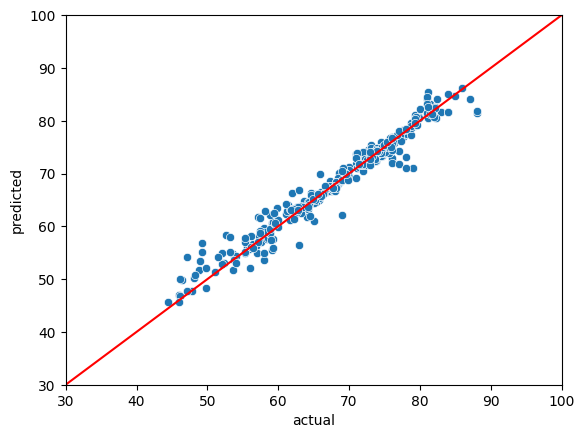

In [16]:
# Plot predicted vs. actual
_ = sns.scatterplot(x = y_test,  y = preds)
_ = plt.plot([30, 100], [30, 100], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(30, 100)
_ = plt.xlabel("actual")
_ = plt.ylabel("predicted")

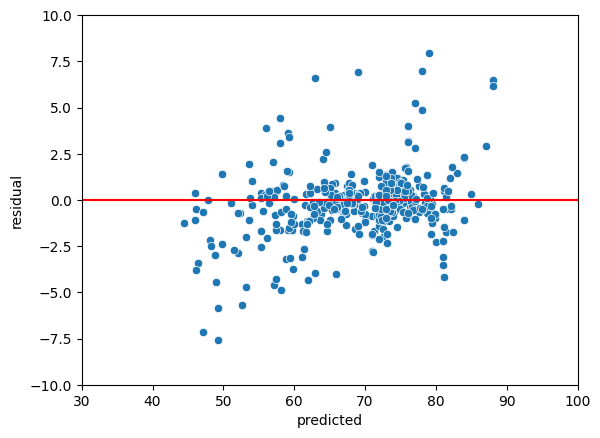

In [17]:
# Predicted vs residual
resids = y_test - preds
_ = sns.scatterplot(x = y_test, y= resids)
_ = plt.plot([30, 100], [0, 0], c = "red")
_ = plt.xlim(30, 100)
_ = plt.ylim(-10, 10)
_ = plt.xlabel("predicted")
_ = plt.ylabel("residual")

## Inference

In [39]:
# Get SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

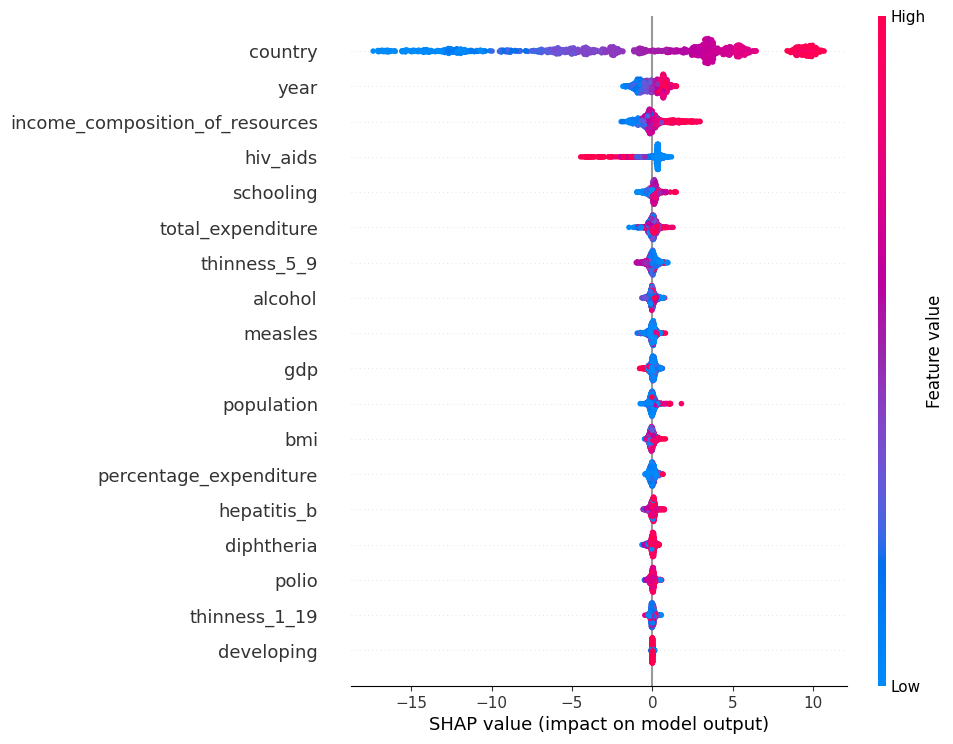

In [41]:
# SHAP summary of all features
shap.plots.beeswarm(shap_values, max_display = 20)

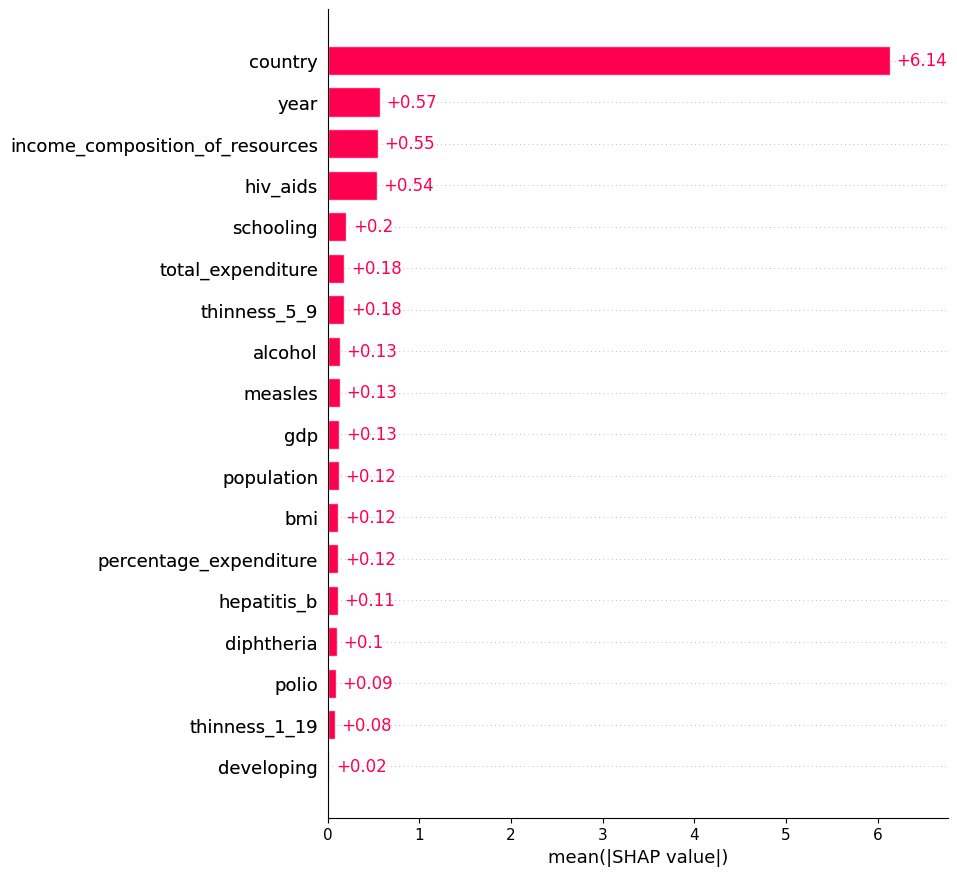

In [42]:
shap.plots.bar(shap_values, max_display = 20)

The predictions are strongly driven by the target encoded country variable.